In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('No Cuda GPU detected.')

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [3]:
def plotPred (y_true, preds):
    ymin = np.min(y_true)
    ymax = np.max(y_true)
    plt.scatter(y_true, preds, label=f'score: {r2_score(y_true, preds)}')
    plt.plot([ymin, ymax], [ymin, ymax], '-.', color='red', label="predicted values = true values")
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()

In [4]:
def buildAndCompile(shape):
    input = tf.keras.Input(shape=(shape,))
    output = layers.Dense(shape, activation='relu')(input)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dense(1)(output)
    model = keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [5]:
rebuild = False
model = None

if rebuild:
    model = buildAndCompile(131)
else:
    model = keras.models.load_model('../Models/SF_model_batch_32M')
    
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 131)]             0         
_________________________________________________________________
dense (Dense)                (None, 131)               17292     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8448      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,805
Trainable params: 25,805
Non-trainable params: 0
_________________________________________________________________


In [6]:
%%time
mode = 'batch'
offset = 0
max_idx = 32
engine = 'Stockfish 13'
model_path = '../Models/SF_model_batch_32M'
'''
if mode == 'all':

    X = []
    y = []

    for i in range(max_idx):
        dataframe_encoded = pd.read_csv('Datasets/' + engine + '/dataset' + str(i+1) + '.csv')
        features = dataframe_encoded.columns[:-1]
        cps = dataframe_encoded.columns[-1]

        if len(X) == 0:
            X = dataframe_encoded[features].values
            y = dataframe_encoded[cps].values
        else:
            X = np.append(X, dataframe_encoded[features].values, axis=0)
            y = np.append(y, dataframe_encoded[cps].values)

    print(X.shape, y.shape)

    history = model.fit(X, y, validation_split=0.1, verbose=0, epochs=50)
    plot_loss(history)
    model.save(model_path, save_format='tf')
    
else:
    
    for i in range(offset, max_idx):
        dataframe_encoded = pd.read_csv('Datasets/' + engine + '/dataset' + str(i+1) + '.csv')
        features = dataframe_encoded.columns[:-1]
        cps = dataframe_encoded.columns[-1]
        X = dataframe_encoded[features].values
        y = dataframe_encoded[cps].values

        model.fit(X, y, validation_split=0.1, verbose=0, epochs=50)
        print(f'Training finished on dataset: dataset{i+1}.csv')
        model.save(model_path, save_format='tf')
'''

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 14.5 µs


"\nif mode == 'all':\n\n    X = []\n    y = []\n\n    for i in range(max_idx):\n        dataframe_encoded = pd.read_csv('Datasets/' + engine + '/dataset' + str(i+1) + '.csv')\n        features = dataframe_encoded.columns[:-1]\n        cps = dataframe_encoded.columns[-1]\n\n        if len(X) == 0:\n            X = dataframe_encoded[features].values\n            y = dataframe_encoded[cps].values\n        else:\n            X = np.append(X, dataframe_encoded[features].values, axis=0)\n            y = np.append(y, dataframe_encoded[cps].values)\n\n    print(X.shape, y.shape)\n\n    history = model.fit(X, y, validation_split=0.1, verbose=0, epochs=50)\n    plot_loss(history)\n    model.save(model_path, save_format='tf')\n    \nelse:\n    \n    for i in range(offset, max_idx):\n        dataframe_encoded = pd.read_csv('Datasets/' + engine + '/dataset' + str(i+1) + '.csv')\n        features = dataframe_encoded.columns[:-1]\n        cps = dataframe_encoded.columns[-1]\n        X = dataframe_enc

In [7]:
test_df = pd.read_csv('Datasets/' + engine + '/test_dataset.csv')
features = test_df.columns[1:-1]
cps = test_df.columns[-1]

boards = test_df[features].values
scores = test_df[cps].values
print(boards.shape, scores.shape)
preds = model.predict(boards).flatten()

(1984645, 131) (1984645,)


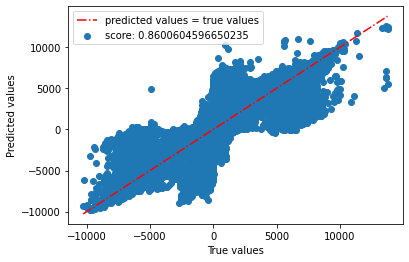

In [10]:
plotPred(scores, preds)
plt.savefig('model32M.png')

#### We test our model with some random positions.

r1bqkb1r/pp3ppp/2n1pn2/2pp4/3P1B2/2P1PN2/PP1N1PPP/R2QKB1R b KQkq - 0 6
stockfish score: 40
pred score: 27


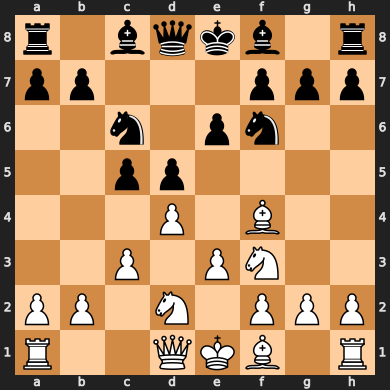

In [37]:
import sys
import chess
sys.path.insert(1, 'Classes/')
from dataset_utils import encodeBoard
from ScoreGetter import ScoreGetter

score_getter = ScoreGetter('/home/gaetan/Documents/Chess/Engines/Stockfish 13/stockfish_13_linux_x64_bmi2', 'eval', 'go depth 1')

df = pd.read_csv('Datasets/raw_dataset.csv', nrows=10000)
fens = df['board'].values

fen = fens[np.random.randint(fens.shape[0])]
print(fen)
e = np.array(encodeBoard(fen)).reshape(1, -1)
print(f'stockfish score: {score_getter.getScore(fen)}')
print(f'pred score: {int(model.predict(e).flatten()[0])}')

chess.Board(fen)